# fartcoin 을 이용한 LSTM 예측
# Stock Price Prediction using Machine Learning
이 노트북에서는 주가 예측을 위한 머신러닝 모델을 구현합니다.

## 주요 내용
- 데이터 불러오기 및 전처리
- 시계열 데이터를 활용한 모델 학습
- 성능 평가 및 시각화

## python 3.10.9 를 사용함

아래의 코드 셀은 데이터 로딩과 기본 전처리를 수행합니다.

In [1]:
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
import time
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback
import lstm_helper_ori as lstm

/Users/sonbyeong-ug/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/sonbyeong-ug/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 테스트코드
# 노멀라이징 하지 않은 실제 데이터를 가져온다.
_, _, _, y_test_ori = lstm.load_data('extracted_close4000.csv', 50, False)

# 차트를 그려본다.
import plotly.graph_objects as go
import numpy as np

y_test_ori_float = list(map(float, y_test_ori))

fig = go.Figure()

# 데이터 추가
fig.add_trace(go.Scatter(
    x=np.arange(len(y_test_ori_float)), 
    y=y_test_ori_float,
    mode='lines',
    name='Actual Price'
))

# 3️⃣ 그래프 레이아웃 설정
fig.update_layout(
    title="Actual vs Predicted Prices Over Time",
    xaxis_title="Time Steps",
    yaxis_title="Price",
    hovermode="x unified"
)

# 인터랙티브 차트 표시
fig.show()

In [3]:
#Step 1 학습을 위한 값을 가져옴
X_train, y_train, X_test, y_test, min_max_y_train, min_max_y_test = lstm.load_data_minmax('extracted_close4000.csv', 50, True)

윈도우 데이터 개수 3950


In [4]:
# 테스트코드
# y_test의 값을 디노멀라이징 한후에 차트에 그려본다.
# 노멀라이징 하지 않은 원본 데이터와 동일한지 확인하기 위한 코드
min_vals = min_max_y_test[:, 0]
max_vals = min_max_y_test[:, 1]
dnormalize_y_test = lstm.min_max_denormalize(y_test, min_vals, max_vals)

# dnormalize_y_test 를 차트에 그려본다.
import plotly.graph_objects as go
import numpy as np

dnormalize_y_test_float = list(map(float, dnormalize_y_test))

fig = go.Figure()

# 데이터 추가
fig.add_trace(go.Scatter(
    x=np.arange(len(dnormalize_y_test_float)), 
    y=dnormalize_y_test_float,
    mode='lines',
    name='Actual Price'
))

# 3️⃣ 그래프 레이아웃 설정
fig.update_layout(
    title="Actual vs Predicted Prices Over Time",
    xaxis_title="Time Steps",
    yaxis_title="Price",
    hovermode="x unified"
)

# 인터랙티브 차트 표시
fig.show()

In [5]:
# Step 2: Build Model
model_dropout = 0.3

model = Sequential()

model.add(LSTM(
    units=50,  # ✅ output_dim → units
    input_shape=(None, 1),  # ✅ input_dim → input_shape 변경
    return_sequences=True))
model.add(Dropout(model_dropout))

model.add(LSTM(
    units=100,  # ✅ output_dim 제거 후 units 적용
    return_sequences=False))
model.add(Dropout(model_dropout))

model.add(Dense(
    units=1))  # ✅ output_dim → units 변경
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print("Compilation time :", time.time() - start)  # ✅ print 수정

2025-03-20 21:08:45.711872: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-03-20 21:08:45.712074: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-20 21:08:45.712086: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-20 21:08:45.712303: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-20 21:08:45.712326: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Compilation time : 0.012542247772216797


100%|██████████| 100/100 [00:37<00:00,  2.69epoch/s, loss=0.0138, val_loss=0.0118]


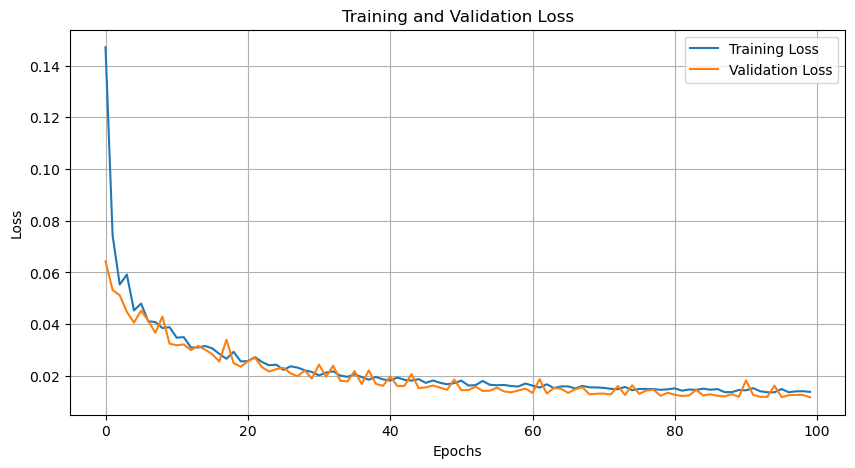

In [6]:
#Step 3 Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=100,  # ✅ nb_epoch → epochs 변경
    validation_split=0.12,
    verbose=0,  # ✅ 기본 로그 숨기기
    callbacks=[TqdmCallback()]  # ✅ tqdm 진행률 바 추가
)

# 학습 과정에서의 손실과 정확도 기록
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 손실 그래프
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
#Step 4 - Plot the predictions!
predictions_index = lstm.predict_sequences_multiple_index(model, X_test, 50, 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

In [8]:
# 예측한 값을 차트에 그리기
min_vals = min_max_y_test[:, 0]
max_vals = min_max_y_test[:, 1]
dnormalize_y_test = lstm.min_max_denormalize(y_test, min_vals, max_vals)

# 예측값을 디노멀라이징 한다.
predictions_index_ndarray = np.array(predictions_index)
dnormalize_prediction = lstm.denormalize_predictions(predictions_index_ndarray, min_max_y_test)

#print(dnormalize_prediction)

# dnormalize_y_test 를 차트에 그려본다.
import plotly.graph_objects as go
import numpy as np

dnormalize_y_test_float = list(map(float, dnormalize_y_test))

fig = go.Figure()

# 데이터 추가
fig.add_trace(go.Scatter(
    x=np.arange(len(dnormalize_y_test_float)), 
    y=dnormalize_y_test_float,
    mode='lines',
    name='Actual Price'
))

# 예측 값 그리기
for predicted_row in dnormalize_prediction:
    indices = [int(item[0]) for item in predicted_row]
    predicted_values = [item[2] for item in predicted_row]
    fig.add_trace(go.Scatter(
        x=indices,
        y=predicted_values,
        mode='lines',
        name='Predicted Price'
    ))

# 3️⃣ 그래프 레이아웃 설정
fig.update_layout(
    title="Actual vs Predicted Prices Over Time",
    xaxis_title="Time Steps",
    yaxis_title="Price",
    hovermode="x unified"
)

# 인터랙티브 차트 표시
fig.show()

In [9]:
# 모델 저장 (전체 모델 저장)
model.save('fartcoin.keras')